In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
from pylab import *
import copy
import time

torch.manual_seed(1)                      # reproducible
torch.set_printoptions(threshold=np.inf)  # print all


# ----- Step 1: Set Hyper Parameters ----- #

model = 'LSTM'
dataset = 'GunPointOldVersusYoung'
NAME = f'{model}-UCR-{dataset}'

train_data_path = f'../Datasets/UCR/{dataset}/{dataset}_TRAIN.tsv'
test_data_path = f'../Datasets/UCR/{dataset}/{dataset}_TEST.tsv'

BATCH_SIZE = 200  # 150
LR = 0.001

TIME_STEP = 150
INPUT_SIZE = 1
OUTPUT_SIZE = 2


# ----- Step 2: Dataset Loading and Preprocessing ----- #

class GetLoader(torch.utils.data.Dataset):      # 定义GetLoader类，继承Dataset方法

    def __init__(self, data_root, data_label):  # 初始化，加载数据
        self.data = data_root
        self.label = data_label

    def __getitem__(self, index):               # index是根据batchsize划分数据得到的索引
        data = self.data[index]
        labels = self.label[index]
        return data, labels

    def __len__(self):                          # 返回数据大小长度，方便DataLoader划分
        return len(self.data)

    
train_text = ''
test_text = ''

train_x = []
train_y = []
test_x = []
test_y = []

with open(train_data_path, 'r') as f:
    train_text = f.read()
train_lines = train_text.split('\n')
for line in train_lines:
    _list = line.split('\t')
    if len(_list) > 1:
        train_y.append(float(_list[0])-1)
        flo_list = [[float(num)] for num in _list[1:]]
        train_x.append(flo_list)

with open(test_data_path, 'r') as f:
    test_text = f.read()
test_lines = test_text.split('\n')
for line in test_lines:
    _list = line.split('\t')
    if len(_list) > 1:
        test_y.append(float(_list[0])-1)
        flo_list = [[float(num)] for num in _list[1:]]
        test_x.append(flo_list)
        
train_x = np.array(train_x)
train_y = np.array(train_y)
test_x = np.array(test_x)
test_y = np.array(test_y)

# for i in range(len(train_y)):  # special pre-processing bacause of the format of the original dataset
#     if train_y[i] == -1:
#         train_y[i] = 1
        
# for i in range(len(test_y)):
#     if test_y[i] == -1:
#         test_y[i] = 1

print('*** Dataset Information ***\ntrain_x:', train_x.shape, '\ntrain_y:', train_y.shape, '\ntest_x:', test_x.shape, '\ntest_y:', test_y.shape)


# 留作每50轮输出当前训练结果用
train_X = copy.deepcopy(train_x)
train_X = torch.from_numpy(train_X).to(torch.float32)
train_Y = copy.deepcopy(train_y)
test_X = torch.from_numpy(test_x).to(torch.float32)
test_Y = test_y

train_x = torch.from_numpy(train_x).to(torch.float32)
train_y = torch.from_numpy(train_y).to(torch.long)
train_data = GetLoader(train_x, train_y)                # 返回Dataset对象(包含data和label)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

train_Y1 = copy.deepcopy(train_y)


# ----- Step 3: Create Model Class ----- #

class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.rnn = nn.LSTM(
            input_size=INPUT_SIZE,
            hidden_size=128,
            num_layers=2,
            batch_first=True
        )
        self.out = nn.Linear(128, OUTPUT_SIZE)

    def forward(self, x):
        r_out, (h_n, h_c) = self.rnn(x, None)  # None represents zero initial hidden state
        out = self.out(r_out[:, -1, :])        # choose r_out at the last time step
        return out


# ----- Step 4: Instantiate ----- #

rnn = RNN()
print('\n*** Model Information ***\n', rnn, '\n\n*** Training Information ***')

optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)
loss_fn = nn.CrossEntropyLoss()   # the target label is not one-hotted


# ----- Step 5: Model Training ----- #

for turns in range(1, 201):
    for batch_idx, (train_x, train_y) in enumerate(train_loader):
        
        train_x = train_x.view(-1, TIME_STEP, INPUT_SIZE)
        output = rnn(train_x)
        loss = loss_fn(output, train_y)
        optimizer.zero_grad()  # clear gradients for this training step
        loss.backward()        # backward and compute gradients
        optimizer.step()       # apply gradients

        train_output = rnn(train_X)
        pred_train_y = torch.max(train_output, 1)[1].data.numpy()
        train_accuracy = float((pred_train_y == train_Y).astype(int).sum()) / float(train_Y.size)
        train_loss = loss_fn(train_output, train_Y1)

        torch.save(rnn, f'../Models/{NAME}/epoch_{turns}_{batch_idx}.pkl')
        print('Epoch: ', turns, '_', batch_idx, '| train loss: %.4f' % train_loss.data.numpy(), '| train accuracy: %.2f' % train_accuracy)


*** Dataset Information ***
train_x: (136, 150, 1) 
train_y: (136,) 
test_x: (315, 150, 1) 
test_y: (315,)

*** Model Information ***
 RNN(
  (rnn): LSTM(1, 128, num_layers=2, batch_first=True)
  (out): Linear(in_features=128, out_features=2, bias=True)
) 

*** Training Information ***
Epoch:  1 _ 0 | train loss: 0.6871 | train accuracy: 0.52


KeyboardInterrupt: 

In [2]:
"""
Finding The Optimum Model Automatically

"""

min_loss = 10000
max_test_acc = 0
corresponding_train_acc = 0

turns_chosen = -1
batch_idx_chosen = -1

for turns in range(10, 19):
    batch_number = int(train_X.shape[0]/BATCH_SIZE)
    if train_X.shape[0] % BATCH_SIZE != 0:
        batch_number += 1
    
    for batch_idx in range(batch_number):
        rnn = torch.load(f'../Models/{NAME}/epoch_{turns}_{batch_idx}.pkl')
        
        train_output = rnn(train_X)
        pred_train_y = torch.max(train_output, 1)[1].data.numpy()
        train_accuracy = float((pred_train_y == train_Y).astype(int).sum()) / float(train_Y.size)
        train_loss = loss_fn(train_output, train_Y1)
        
        test_output = rnn(test_X)
        pred_test_y = torch.max(test_output, 1)[1].data.numpy()
        test_accuracy = float((pred_test_y == test_Y).astype(int).sum()) / float(test_Y.size)
        
        test_acc_bias = test_accuracy - max_test_acc
        loss_bias = train_loss.data.numpy() - min_loss
        if test_acc_bias >= 0.01 or (test_acc_bias >= 0 and test_acc_bias < 0.01 and loss_bias < 0.1):
            max_test_acc = test_accuracy
            min_loss = train_loss.data.numpy()
            corresponding_train_acc = train_accuracy
            turns_chosen = turns
            batch_idx_chosen = batch_idx

print('*** The Optimum Model ***\nEpoch Index: ', turns_chosen, '_', batch_idx_chosen)
print('Train Loss: %.6f' % min_loss, '\nTrain Accuracy: %.4f' % corresponding_train_acc, '\nTest Accuracy: %.4f' % max_test_acc)


*** The Optimum Model ***
Epoch Index:  13 _ 0
Train Loss: 0.102776 
Train Accuracy: 0.9926 
Test Accuracy: 0.9778


In [3]:
import torchattacks


print('*** FGSM ***')

FGSM_time_part_start = time.time()
attack_FGSM = torchattacks.FGSM(rnn, eps=0.007)
adv_X_FGSM = attack_FGSM(train_X, torch.from_numpy(train_Y).to(torch.long))
FGSM_time_part_stop = time.time()
FGSM_average_time_cost = (FGSM_time_part_stop - FGSM_time_part_start) / adv_X_FGSM.shape[0]
print('\n Average Time Cost:', FGSM_average_time_cost)

adv_output_FGSM = rnn(adv_X_FGSM)
pred_adv_y_FGSM = torch.max(adv_output_FGSM, 1)[1].data.numpy()
adv_accuracy_FGSM = float((pred_adv_y_FGSM == train_Y).astype(int).sum()) / float(train_Y.size)
print('\n Success Rate of Adversarial Attack: %.2f' % ((1-adv_accuracy_FGSM)*100), '%')

test_acc_num = (pred_test_y == test_Y).astype(int).sum()
adv_acc_num_FGSM = (pred_adv_y_FGSM == train_Y).astype(int).sum()
test_adv_total_num_FGSM = test_Y.size + train_Y.size
attacked_test_accuracy_FGSM = float(test_acc_num + adv_acc_num_FGSM) / float(test_adv_total_num_FGSM)
print('\n Attacked RNN Test Accuracy: %.4f' % attacked_test_accuracy_FGSM)

sum_distance = 0
for i in range(train_X.shape[0]):
    for j in range(train_X.shape[1]):
        sum_distance += abs(adv_X_FGSM[i, j, 0] - train_X[i, j, 0])
average_distance = sum_distance / train_X.shape[0]
print('\n Average Perturbation:', average_distance)


# print('\n*** FAB ***')

# FAB_time_part_start = time.time()
# attack_FAB = torchattacks.FAB(rnn, norm='Linf', steps=1, eps=None, n_restarts=1, alpha_max=0.1, eta=1.05, beta=0.9, verbose=False, seed=0, targeted=False, n_classes=2)
# adv_X_FAB = attack_FAB(train_X, torch.from_numpy(train_Y).to(torch.long))
# FAB_time_part_stop = time.time()
# FAB_average_time_cost = (FAB_time_part_stop - FAB_time_part_start) / adv_X_FAB.shape[0]
# print('\n FAB_average_time_cost:', FAB_average_time_cost)

# adv_output_FAB = rnn(adv_X_FAB)
# pred_adv_y_FAB = torch.max(adv_output_FAB, 1)[1].data.numpy()
# adv_accuracy_FAB = float((pred_adv_y_FAB == train_Y).astype(int).sum()) / float(train_Y.size)
# print('\n Success Rate of Adversarial Attack: %.2f' % ((1-adv_accuracy_FAB)*100), '%')


# test_acc_num = (pred_test_y == test_Y).astype(int).sum()
# adv_acc_num_FAB = (pred_adv_y_FAB == train_Y).astype(int).sum()
# test_adv_total_num_FAB = test_Y.size + train_Y.size
# attacked_test_accuracy_FAB = float(test_acc_num + adv_acc_num_FAB) / float(test_adv_total_num_FAB)
# print('\n Attacked RNN Test Accuracy: %.4f' % attacked_test_accuracy_FAB)

# sum_distance = 0
# for i in range(train_X.shape[0]):
#     for j in range(train_X.shape[1]):
#         sum_distance += abs(adv_X_FAB[i, j, 0] - train_X[i, j, 0])
# average_distance = sum_distance / train_X.shape[0]
# print('\n Average Perturbation:', average_distance)


print('\n*** DeepFool ***')

DeepFool_time_part_start = time.time()
attack_DeepFool = torchattacks.DeepFool(rnn, steps=50, overshoot=0.02)
adv_X_DeepFool = attack_DeepFool(train_X, torch.from_numpy(train_Y).to(torch.long))
DeepFool_time_part_stop = time.time()
DeepFool_average_time_cost = (DeepFool_time_part_stop - DeepFool_time_part_start) / adv_X_DeepFool.shape[0]
print('\n DeepFool_average_time_cost:', DeepFool_average_time_cost)

adv_output_DeepFool = rnn(adv_X_DeepFool)
pred_adv_y_DeepFool = torch.max(adv_output_DeepFool, 1)[1].data.numpy()
adv_accuracy_DeepFool = float((pred_adv_y_DeepFool == train_Y).astype(int).sum()) / float(train_Y.size)
print('\n Success Rate of Adversarial Attack: %.2f' % ((1-adv_accuracy_DeepFool)*100), '%')

test_acc_num = (pred_test_y == test_Y).astype(int).sum()
adv_acc_num_DeepFool = (pred_adv_y_DeepFool == train_Y).astype(int).sum()
test_adv_total_num_DeepFool = test_Y.size + train_Y.size
attacked_test_accuracy_DeepFool = float(test_acc_num + adv_acc_num_DeepFool) / float(test_adv_total_num_DeepFool)
print('\n Attacked RNN Test Accuracy: %.4f' % attacked_test_accuracy_DeepFool)

sum_distance = 0
for i in range(train_X.shape[0]):
    for j in range(train_X.shape[1]):
        sum_distance += abs(adv_X_DeepFool[i, j, 0] - train_X[i, j, 0])
average_distance = sum_distance / train_X.shape[0]
print('\n Average Perturbation:', average_distance)


*** FGSM ***

 Average Time Cost: 0.009563817697412828

 Success Rate of Adversarial Attack: 47.79 %

 Attacked RNN Test Accuracy: 0.7583

 Average Perturbation: tensor(88245.6562)

*** DeepFool ***

 DeepFool_average_time_cost: 4.946950349737616

 Success Rate of Adversarial Attack: 47.79 %

 Attacked RNN Test Accuracy: 0.7583

 Average Perturbation: tensor(79016.4375)


In [11]:
# Standard Range Distance

low_0 = 16776960
high_0 = 0
low_1 = 16776960
high_1 = 0

for i in range(train_X.shape[0]):
    current_sample = 0
    for j in range(train_X.shape[1]):
        current_sample += train_X[i, j, 0]
    
    if train_Y[i] == 0:
        if current_sample > high_0:
            high_0 = current_sample
        if current_sample < low_0:
            low_0 = current_sample
            
    if train_Y[i] == 1:
        if current_sample > high_1:
            high_1 = current_sample
        if current_sample < low_1:
            low_1 = current_sample

range_distance_0 = high_0 - low_0
range_distance_1 = high_1 - low_1

print(range_distance_0)
print(range_distance_1)

tensor(18567.7930)
tensor(85709.9531)


In [13]:
# Over All

self_count = 0
other_count = 0
self_distance = 0
other_distance = 0

for i in range(train_X.shape[0]):
    if train_Y[i] == 0:
        self_range_distance = range_distance_0
        other_range_distance = range_distance_1
    else:
        self_range_distance = range_distance_1
        other_range_distance = range_distance_0
    
    for k in range(train_X.shape[0]):
        if train_Y[i] == train_Y[k]:
            self_count += 1
            current_self_distance = 0
            for j in range(train_X.shape[1]):
                current_self_distance += abs(adv_X_FGSM[i, j, 0] - train_X[k, j, 0])
            self_distance += current_self_distance / self_range_distance                
        else:
            other_count += 1
            current_other_distance = 0
            for j in range(train_X.shape[1]):
                current_other_distance += abs(adv_X_FGSM[i, j, 0] - train_X[k, j, 0])
            other_distance += current_other_distance / other_range_distance     

distance_rate = (self_distance/self_count) / (other_distance/other_count)
print('\n FGSM Distance Rate:', distance_rate)


self_count = 0
other_count = 0
self_distance = 0
other_distance = 0

for i in range(train_X.shape[0]):
    if train_Y[i] == 0:
        self_range_distance = range_distance_0
        other_range_distance = range_distance_1
    else:
        self_range_distance = range_distance_1
        other_range_distance = range_distance_0
    
    for k in range(train_X.shape[0]):
        if train_Y[i] == train_Y[k]:
            self_count += 1
            current_self_distance = 0
            for j in range(train_X.shape[1]):
                current_self_distance += abs(adv_X_DeepFool[i, j, 0] - train_X[k, j, 0])
            self_distance += current_self_distance / self_range_distance                
        else:
            other_count += 1
            current_other_distance = 0
            for j in range(train_X.shape[1]):
                current_other_distance += abs(adv_X_DeepFool[i, j, 0] - train_X[k, j, 0])
            other_distance += current_other_distance / other_range_distance     

distance_rate = (self_distance/self_count) / (other_distance/other_count)
print('\n DeepFool Distance Rate:', distance_rate)



 FGSM Distance Rate: tensor(0.9679)

 DeepFool Distance Rate: tensor(0.8437)


In [15]:
# Only Adv

self_count = 0
other_count = 0
self_distance = 0
other_distance = 0

for i in range(train_X.shape[0]):
    if pred_adv_y_FGSM[i] == train_Y[i]:
        continue
    
    if train_Y[i] == 0:
        self_range_distance = range_distance_0
        other_range_distance = range_distance_1
    else:
        self_range_distance = range_distance_1
        other_range_distance = range_distance_0
    
    for k in range(train_X.shape[0]):
        if train_Y[i] == train_Y[k]:
            self_count += 1
            current_self_distance = 0
            for j in range(train_X.shape[1]):
                current_self_distance += abs(adv_X_FGSM[i, j, 0] - train_X[k, j, 0])
            self_distance += current_self_distance / self_range_distance                
        else:
            other_count += 1
            current_other_distance = 0
            for j in range(train_X.shape[1]):
                current_other_distance += abs(adv_X_FGSM[i, j, 0] - train_X[k, j, 0])
            other_distance += current_other_distance / other_range_distance     

distance_rate = (self_distance/self_count) / (other_distance/other_count)
print('\n FGSM Distance Rate:', distance_rate)


self_count = 0
other_count = 0
self_distance = 0
other_distance = 0

for i in range(train_X.shape[0]):
    if pred_adv_y_DeepFool[i] == train_Y[i]:
        continue
    
    if train_Y[i] == 0:
        self_range_distance = range_distance_0
        other_range_distance = range_distance_1
    else:
        self_range_distance = range_distance_1
        other_range_distance = range_distance_0
    
    for k in range(train_X.shape[0]):
        if train_Y[i] == train_Y[k]:
            self_count += 1
            current_self_distance = 0
            for j in range(train_X.shape[1]):
                current_self_distance += abs(adv_X_DeepFool[i, j, 0] - train_X[k, j, 0])
            self_distance += current_self_distance / self_range_distance                
        else:
            other_count += 1
            current_other_distance = 0
            for j in range(train_X.shape[1]):
                current_other_distance += abs(adv_X_DeepFool[i, j, 0] - train_X[k, j, 0])
            other_distance += current_other_distance / other_range_distance     

distance_rate = (self_distance/self_count) / (other_distance/other_count)
print('\n DeepFool Distance Rate:', distance_rate)



 FGSM Distance Rate: tensor(2.1331)

 DeepFool Distance Rate: tensor(1.8517)


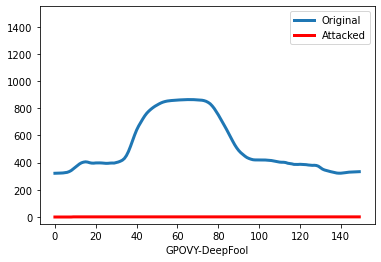

In [9]:
LABEL = 'GPOVY'
timestep_record = [i for i in range(adv_X_FGSM.shape[1])]


# plt.plot(timestep_record, train_X[87], '-', linewidth=3, color='#1f77b4', label='Original')
# plt.plot(timestep_record, adv_X_FGSM[87], '-', linewidth=3, color='red', label='Attacked')
# plt.xlabel(f"{LABEL}-FGSM")
# plt.ylim(-50, 1550)
# plt.legend()
# plt.savefig(f'../Savefig/{LABEL}-FGSM.png', bbox_inches='tight', dpi=600)
# plt.show()


# plt.plot(timestep_record, train_X[87], '.', color='#1f77b4', label='Original')
# plt.plot(timestep_record, adv_X_DeepFool[87], '.', color='red', label='Attacked')
# LABEL = 'DeepFool'
# plt.xlabel(f"{LABEL}-DeepFool")
# plt.ylim(-50, 1050)
# plt.savefig(f'../Savefig/{LABEL}-DeepFool.png', bbox_inches='tight', dpi=600)
# plt.show()


plt.plot(timestep_record, train_X[87], '-', linewidth=3, color='#1f77b4', label='Original')
plt.plot(timestep_record, adv_X_DeepFool[87], '-', linewidth=3, color='red', label='Attacked')
plt.xlabel(f"{LABEL}-DeepFool")
plt.ylim(-50, 1550)
plt.legend()
plt.savefig(f'../Savefig/{LABEL}-DeepFool.png', bbox_inches='tight', dpi=600)
plt.show()


In [16]:
print(self_distance/self_count)
print(other_distance/other_count)

tensor(2.1555)
tensor(1.1640)


In [17]:
# Avg Sample and Avg Distance

sum_train_X_0 = train_X[0] - train_X[0]
sum_train_X_1 = train_X[0] - train_X[0]
count_train_X_0 = 0
count_train_X_1 = 0
for i in range(train_X.shape[0]):
    if train_Y[i] == 0:
        count_train_X_0 += 1
        sum_train_X_0 += train_X[i]
    if train_Y[i] == 1:
        count_train_X_1 += 1
        sum_train_X_1 += train_X[i]
avg_train_X_0 = sum_train_X_0 / count_train_X_0
avg_train_X_1 = sum_train_X_1 / count_train_X_1

distance_train_X_0 = 0
distance_train_X_1 = 0
for i in range(train_X.shape[0]):
    current_distance = 0
    if train_Y[i] == 0:
        for j in range(train_X.shape[1]):
            current_distance += abs(train_X[i, j, 0] - avg_train_X_0[j, 0])
        distance_train_X_0 += current_distance
    if train_Y[i] == 1:
        for j in range(train_X.shape[1]):
            current_distance += abs(train_X[i, j, 0] - avg_train_X_1[j, 0])
        distance_train_X_1 += current_distance
avg_distance_train_X_0 = distance_train_X_0 / count_train_X_0
avg_distance_train_X_1 = distance_train_X_1 / count_train_X_1

print(avg_distance_train_X_0)
print(avg_distance_train_X_1)


# Only Adv

self_distance = 0
other_distance = 0

for i in range(train_X.shape[0]):
    if pred_adv_y_FGSM[i] == train_Y[i]:
        continue

    if train_Y[i] == 0:
        self_avg_train_X = avg_train_X_0
        other_avg_train_X = avg_train_X_1
        self_avg_distance = avg_distance_train_X_0
        other_avg_distance = avg_distance_train_X_1
    else:
        self_avg_train_X = avg_train_X_1
        other_avg_train_X = avg_train_X_0
        self_avg_distance = avg_distance_train_X_1
        other_avg_distance = avg_distance_train_X_0

    current_self_distance = 0
    for j in range(train_X.shape[1]):
        current_self_distance += abs(adv_X_FGSM[i, j, 0] - self_avg_train_X[j, 0])
    self_distance += current_self_distance / self_avg_distance
    
    current_other_distance = 0
    for j in range(train_X.shape[1]):
        current_other_distance += abs(adv_X_FGSM[i, j, 0] - other_avg_train_X[j, 0])
    other_distance += current_other_distance / other_avg_distance

cam_rate =  self_distance / other_distance
print('\n FGSM Cam Rate:', cam_rate)
print(self_distance)
print(other_distance)


self_distance = 0
other_distance = 0

for i in range(train_X.shape[0]):
    if pred_adv_y_DeepFool[i] == train_Y[i]:
        continue

    if train_Y[i] == 0:
        self_avg_train_X = avg_train_X_0
        other_avg_train_X = avg_train_X_1
        self_avg_distance = avg_distance_train_X_0
        other_avg_distance = avg_distance_train_X_1
    else:
        self_avg_train_X = avg_train_X_1
        other_avg_train_X = avg_train_X_0
        self_avg_distance = avg_distance_train_X_1
        other_avg_distance = avg_distance_train_X_0

    current_self_distance = 0
    for j in range(train_X.shape[1]):
        current_self_distance += abs(adv_X_DeepFool[i, j, 0] - self_avg_train_X[j, 0])
    self_distance += current_self_distance / self_avg_distance
    
    current_other_distance = 0
    for j in range(train_X.shape[1]):
        current_other_distance += abs(adv_X_DeepFool[i, j, 0] - other_avg_train_X[j, 0])
    other_distance += current_other_distance / other_avg_distance

cam_rate =  self_distance / other_distance
print('\n DeepFool Cam Rate:', cam_rate)
print(self_distance)
print(other_distance)


tensor(6356.8179)
tensor(32528.4258)

 FGSM Cam Rate: tensor(2.3647)
tensor(561.2692)
tensor(237.3575)

 DeepFool Cam Rate: tensor(2.0197)
tensor(401.4088)
tensor(198.7464)
